# Using Cardiac Factors To Predict Whether Individuals Will Experience Heart Failure
#### Harsh A, Kyle M, Daniel L, Catarina A 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [ ]:
set.seed(50)
heart_data <- read_csv("data/heart.csv", skip = 1, col_names = c("age","sex","chest_pain","resting_bp","cholesterol","fasting_bs","rest_ecg","max_heart_rate","excercise_angina","old_peak","st_slope","heart_failure")) |>
    mutate(heart_failure = case_when(heart_failure == 1 ~ "Healthy" , heart_failure == 0 ~ "Failed"), heart_failure = as_factor(heart_failure)) |>
    select(age, resting_bp, cholesterol, max_heart_rate, heart_failure) 

heart_data


heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_failure)

heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_training_summary <- heart_training |>
    group_by(heart_failure) |>
    summarize (patients = n(),
              mean_age = mean(age),
              mean_resting_bp = mean(resting_bp),
              mean_cholesterol = mean(cholesterol),
              mean_max_heart_rate = mean(max_heart_rate))
heart_training_summary

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
45,accuracy,binary,0.7267794,5,0.007825399,Preprocessor1_Model11
46,accuracy,binary,0.7267794,5,0.007825399,Preprocessor1_Model12
43,accuracy,binary,0.7267689,5,0.009145467,Preprocessor1_Model09
⋮,⋮,⋮,⋮,⋮,⋮,⋮
40,accuracy,binary,0.7151217,5,0.009516076,Preprocessor1_Model06
37,accuracy,binary,0.7122126,5,0.012472421,Preprocessor1_Model03
38,accuracy,binary,0.7122126,5,0.012472421,Preprocessor1_Model04


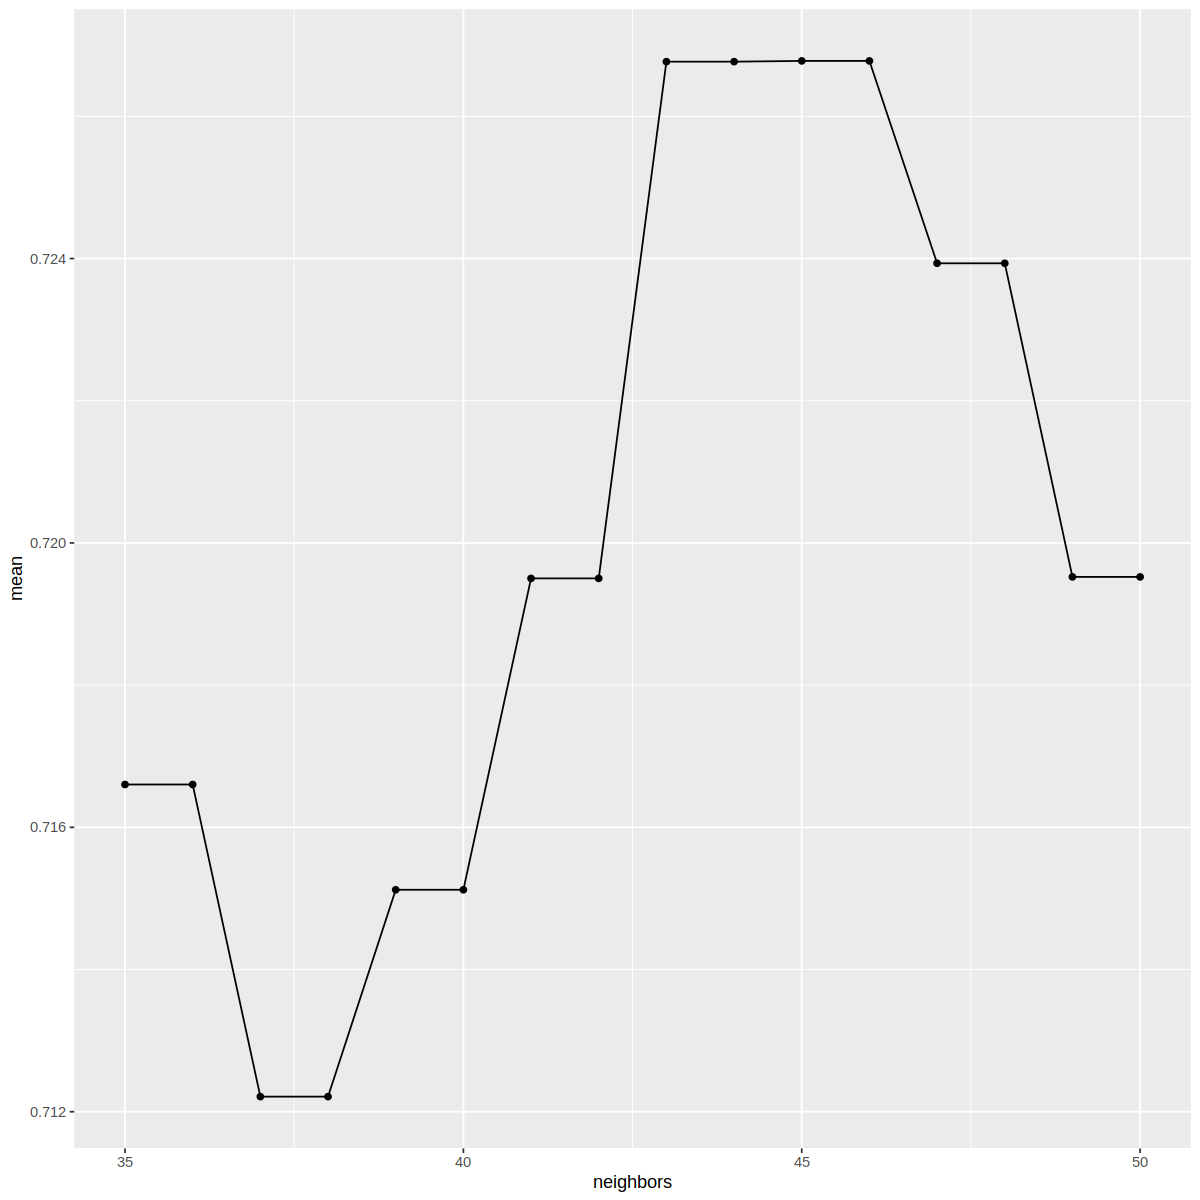

In [42]:
options(repr.plot.height = 10, repr.plot.width = 10)
#set.seed(50)
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn")|>
set_mode("classification")

rec <- recipe(heart_failure~.,data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

fold <- vfold_cv(heart_training, v = 5, strata = heart_failure)

resample_fit <- workflow() |>
       add_recipe(rec) |>
       add_model(spec) |>
       tune_grid(resamples = fold, grid = tibble(neighbors = seq(35,50,by=1))) |>
        collect_metrics() |>
        filter(.metric=="accuracy") |>
        arrange(desc(mean))
resample_fit

plot <- ggplot(resample_fit, aes(x = neighbors, y = mean)) +
    geom_point()+
    geom_line()
plot